# Outline

** Evaluating quality of feedback**

1. Modeling feedback bias
    * Revenge patterns in evaluation of feedback quality
    * Length of feedback vs. perceived quality <br><br>
    
2. Results
    * Time spent on feedback vs. feedback quality
    * Handin quality vs. feedback quality. Does bad handins get bad feedback?
    * Handin ability vs. feedback ability. Does good students give good feedback?
    * Evaluation criteria: Common characteristics of criteria that leads to good feedback.

# Modeling feedback bias

### Imports

In [1]:
%matplotlib inline
import numpy as np
import pymongo as pm
from bson.objectid import ObjectId
from collections import defaultdict, Counter
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from scipy import stats
import dateutil.parser
from langdetect import detect
from afinn import Afinn
import enchant
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

### Settings

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
plt.style.use(["classic"])

### Utility functions

In [3]:
def get_connection():
    con = pm.Connection()
    db = con.heroku_rnwkcq9r
    return db

def smooth(y, box_pts):
    """Sliding box smoothening of noisy data.

    Parameters
    ----------
    y : list
        Noisy y-variable. Must be sorted wrt. time.

    box_pts : int
        Convolution box size. The greater the box the smoother the plot.

    Output
    ------
    y_smooth : list
        Smooth points to replace y. Same dimensions as y.

    Example
    -------
    x = np.linspace(0,2*np.pi,100)
    y = np.sin(x) + np.random.random(100) * 0.8

    plt.plot(x, y,'o')
    plt.plot(x, smooth(y, 18), 'r-', lw=2)
    plt.plot(x, smooth(y,9), 'g-', lw=2)
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def mean_confidence_interval(data, confidence=0.999999999):
    data = 1.0 * np.array(data)
    m, se = np.mean(data), stats.sem(data)
    h = se * stats.t._ppf((1 + confidence) / 2.0, len(data) - 1)
    return h


## Revenge patterns in evaluation of feedback quality

Is negative feedback rated as less constructive? Is positive feedback rated as more constructive?

In [4]:
# Connect to database
db = get_connection()

In [6]:
# Main data structure to write to. Every entry is feedback from one person to one handin
ds = defaultdict(lambda: defaultdict(list))

# Book keeping for normalization
handins = defaultdict(list)
assignments = defaultdict(list)
courses = defaultdict(list)

length_of_collection = db['answer'].find({"numerical_answer": {"$exists": True}}).count()
start_date = dateutil.parser.parse('2016-03-30T22:01:37.000Z')

# For printing progress
increments = np.arange(0, length_of_collection, length_of_collection/10)

count_total = 0
count_missing_numericalAnswer = 0
count_missing_feedback_grade = 0
count_no_answer = 0
count_too_old = 0
count_demo = 0

c = -1
for answer in db['answer'].find({"_id": {"$gt": ObjectId("56fc4c600000000000000000")}}):
    
    c += 1  # Progress counter
    if c in increments:
        print str(list(increments).index(c) * 10) + "%",
        
    # Only use data from after march 31. 2016 where constructive score feature was implemented
    if answer['report_grade'].generation_time < start_date:
        count_too_old += 1
        continue
    
    # Question pertaining to answer in loop
    question = list(db['question'].find({"_id": answer["question"]}))[0]
        
    # Compute normalized numerical score. If rubric doesn't have one, set it 
    # to None, and handle it down the road.
    if "numericalAnswers" in question and "numerical_answer" in answer:
        normalized_score = answer['numerical_answer'] * 1.0 / max(map(int, question['numericalAnswers'].keys()))
    elif "boolean_answer" in answer:
        normalized_score = answer['boolean_answer'] * 1.0
    else:
        continue
    
    # Handle incomplete data
    try:
        report_grade = list(db['report_grade'].find({"_id": answer['report_grade']}))[0]
        course = list(db['assignment'].find({"_id": report_grade['assignment']}))[0]['course']
    except IndexError:
        # document doesn't exist in report_grade
        count_no_answer += 1
        continue
        
    # Avoid demo courses!
    if "demo" in list(db['course'].find({"_id": course}))[0]["title"].lower():
        continue
        
    # Some gradings don't have feedback grades
    if not "feedback_grade" in report_grade:
        count_missing_feedback_grade += 1
        feedback_grade = 0
    else:
        feedback_grade = report_grade['feedback_grade']
    
    count_total += 1
    
    giver_handin = str(report_grade['giver']) + str(report_grade['handin'])
    
    ds[giver_handin]['normalized_scores'].append(normalized_score)
    ds[giver_handin]['feedback_grade'] = feedback_grade
    
    # For later normalization wrt. different stuff
    ds[giver_handin]['handin'] = report_grade['handin']
    ds[giver_handin]['assignment'] = report_grade['assignment']
    ds[giver_handin]['course'] = course
    
    assignments[report_grade['assignment']].append(normalized_score)
    handins[report_grade['handin']].append(normalized_score)
    courses[course].append(normalized_score)

 0% 10% 20% 30% 40% 50% 60% 70% 80% 90%


###  Data report

In [7]:
print "Entries before march 31. 2016:", count_too_old * 1.0 / count_total
print "Missing numerical_answer:", count_missing_numericalAnswer * 1.0 / count_total
print "Missing feedback_grade:", count_missing_feedback_grade * 1.0 / count_total
print "Entries of demo courses:", count_demo * 1.0 / count_total
print "Causes IndexError:", count_no_answer * 1.0 / count_total

Entries before march 31. 2016: 0.0235974229045
Missing numerical_answer: 0.0
Missing feedback_grade: 0.836446566792
Entries of demo courses: 0.0
Causes IndexError: 0.000155715740915


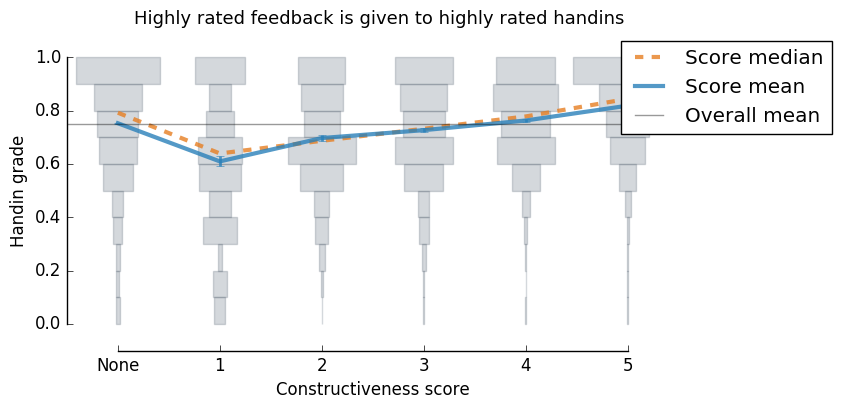

In [14]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(np.mean(v['normalized_scores']))
    
nbins=10
fig, ax = plt.subplots(1, 1, figsize=(10, 4), frameon=False)

hists_mean = np.mean([v for h in hists.values() for v in h])
hists_median = np.median([v for h in hists.values() for v in h])

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    medians.append(np.median(h))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, bins = np.histogram(h, bins=np.linspace(0, 1, 11), normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        w = bc/3.75
        rect = mpatches.Rectangle([v-w/2, b], w, 1.0/nbins, lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

annotation_scale = 0.85
plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8, label="Score median")
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8, label="Score mean")
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)

plt.plot([-0.5, 5], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4, label="Overall mean")

plt.legend()
# Legend
# rect = mpatches.Rectangle([5.6, hists_mean + 0.03 - 0.2 * annotation_scale], 1.5, 0.45, lw=0)
# collection = PatchCollection([rect], color="#2c3e50", alpha=0.1)
# ax.add_collection(collection)

# plt.annotate("Score median", (5.8, hists_mean + 0.064 + 0.1 * annotation_scale), fontsize=12)
# plt.annotate("Score mean", (5.8, hists_mean + 0.064 + 0.0 * annotation_scale), fontsize=12)
# plt.annotate("Overall mean", (5.8, hists_mean + 0.064 - 0.1 * annotation_scale), fontsize=12)

# Axes
plt.xlim([-0.5, 7.1])
plt.ylim([-0.1, 1.1])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Constructiveness score                               ", fontsize=12)
plt.ylabel("Handin grade", fontsize=12)

sns.despine(trim=True)
plt.title("Highly rated feedback is given to highly rated handins                          ", fontsize=13)
#plt.savefig("../figures/revenge01.pdf")
plt.show()

### Effect size

In [356]:
def _slope(hists):
    x, y = [], []
    for v, h in hists.items():
        if v > 0:
            x.extend([v]*len(h))
            y.extend(h)
    return stats.linregress(x, y)

slope, intercept, r_value, p_value, std_err = _slope(hists)
print slope, intercept, r_value, p_value, std_err

# shared variance
print r_value ** 2

0.0506091076211 0.548485488054 0.309274241914 2.38761258956e-58 0.00306367867279
0.0956505567114


The highest feedback quality grades are given to reviews that assign high scores to handins. This could mean that, as suspected, students have a tendency to rate positie feedback as good, but it could also mean that feedback is in fact better when handins are better. It is possible that there is a bias towards putting in more effort to giving better feedback when reviewing a handins that "deserve it", as opposed to work where the grader assesses that that the graded student didn't try hard enough.

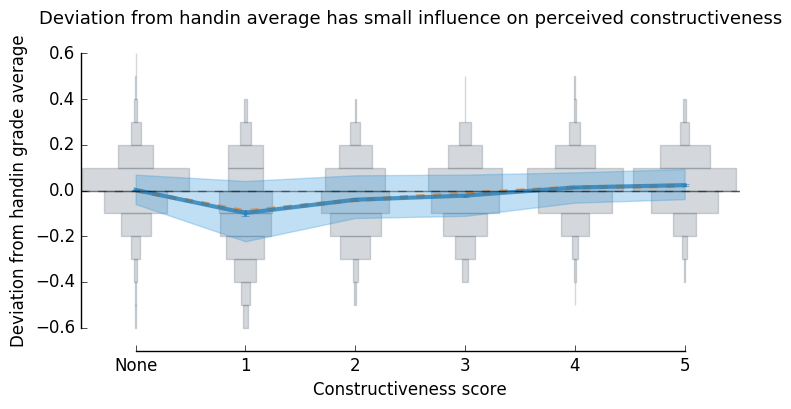

In [357]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(handins[v['handin']])
    )

bins = np.linspace(-0.6, 0.6, 13)

hists_mean = np.mean([v for h in hists.values() for v in h])
hists_median = np.median([v for h in hists.values() for v in h])

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), frameon=False)

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    medians.append(np.median(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, bins = np.histogram(h, bins=bins, normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        if bc == 0: continue
        w = bc/4.2
        rect = mpatches.Rectangle([v-w/2, b], w, abs(bins[0]-bins[1]), lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)
plt.fill_between(range(6), lq, uq, color="#3498db", alpha="0.3")

plt.plot([-0.5, 5.5], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4)
plt.plot([-0.5, 5.5], [hists_median, hists_median], c="k", lw=1, alpha=0.4, ls="--")

plt.xlim([-0.5, 5.5])
plt.ylim([-0.7, 0.7])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6], fontsize=12)

plt.xlabel("Constructiveness score", fontsize=12)
plt.ylabel("Deviation from handin grade average", fontsize=12)

sns.despine(trim=True)
plt.title("Deviation from handin average has small influence on perceived constructiveness", fontsize=13)
plt.savefig("../figures/revenge1.png")
plt.show()

This figure shows that there is very little tendency for students to review feedback as better just because it is very positive relative to the average of all peergradings. This is interesting because it means that it is in fact rarely the case that students avenge negative feedback by rating the feedback quality poorly. This means that it is in fact very likely that students are more careful and tend to give better feedback when grading *good* handins.

### Effect size

In [26]:
def _slope(hists):
    x, y = [], []
    for v, h in hists.items():
        if v > 0:
            x.extend([v]*len(h))
            y.extend(h)
    return stats.linregress(x, y)

slope, intercept, r_value, p_value, std_err = _slope(hists)
print slope, intercept, r_value, p_value, std_err

# shared variance
print r_value ** 2

0.0276574189001 -0.105149582609 0.235933071757 5.41364724324e-34 0.00224272565121
0.0556644143485


## Highlevel feedback features vs. constructiveness score

In [1588]:
d_en = enchant.Dict("en_US")

course_lang = defaultdict(list)
get_lang_returns = []

def get_lang(course, sentence):
    if course in globals()['course_lang']:
        return Counter(globals()['course_lang'][course]).most_common(1)[0][0]
    try:
        lang = detect(sentence)
        globals()['course_lang'][course].append(lang)
        return lang
    except: #LangDetectException
        return None
    
def typo_rate(course, sentence):
    """Fraction if words in sentence that are typos."""
    if get_lang(course, sentence) != "en":
        return None
    return np.sum([not d_en.check(w) for w in sentence.split()])

def afinn_rate(course, sentence):
    lang = get_lang(course, sentence)
    globals()['get_lang_returns'].append(lang)
    if lang not in ["en", "da"]:
        return None
    return Afinn(language=lang).score(sentence)

In [1589]:
# Main data structure to write to. Every entry is feedback from one person to one handin
# ds1 = defaultdict(lambda: defaultdict(list))

# # Book keeping for normalization
# handins = defaultdict(list)
# assignments = defaultdict(list)
# courses = defaultdict(list)

start_date = dateutil.parser.parse('2016-03-30T22:01:37.000Z')

# For printing progress
length_of_collection = db['answer'].find({"_id": {"$gt": ObjectId("56fc4c600000000000000000")}}).count()
increments = np.arange(0, length_of_collection, length_of_collection/10)

breaker = []

c = -1
for answer in db['answer'].find({"_id": {"$gt": ObjectId("56fc4c600000000000000000")}}):

    # Progress counter
    c += 1
    if c in increments:
        print str(list(increments).index(c) * 10) + "%",
        
    # Get question, course and report_grade
    try:
        brokeit="question"
        question = list(
            db['question'].find({"_id": answer["question"]})
        )[0]
        brokeit="report_grade"
        report_grade = list(
                db['report_grade'].find({"_id": answer['report_grade']})
        )[0]
        brokeit="course"
        course = list(
            db['assignment'].find({"_id": report_grade['assignment']})
        )[0]['course']
    except IndexError:
        # something is wrong with this course
        breaker.append(brokeit)
        continue
    
    # Avoid demo courses!
    if "demo" in list(db['course'].find({"_id": course}))[0]["title"].lower():
        continue

    # Compute normalized numerical score. If rubric doesn't have one, set it 
    # to None, and handle it down the road.
    if "numericalAnswers" in question and "numerical_answer" in answer:
        normalized_score = answer['numerical_answer'] * 1.0 / max(map(int, question['numericalAnswers'].keys()))
    elif "boolean_answer" in answer:
        normalized_score = answer['boolean_answer'] * 1.0
    else:
        normalized_score = None
        
    # Extract text features
    if not 'text_answer' in answer or answer['text_answer'] is None:
        text_length = None
        text_valence = None
        text_typo_rate = None
    else:
        text_length = len(answer['text_answer'])
        text_valence = afinn_rate(course, answer['text_answer'])
        text_typo_rate = typo_rate(course, answer['text_answer'])


    # Set constructive score to zero when it was not given
    if not "feedback_grade" in report_grade:
        feedback_grade = 0
    else:
        feedback_grade = report_grade['feedback_grade']
        if report_grade['feedback_grade'] == 0:
            print "non-demo course has 0 feedback_grade"

    # Feedback case Id
    giver_handin = str(report_grade['giver']) + str(report_grade['handin'])

    # Fill in to main datastructure
    if normalized_score is not None:
        ds1[giver_handin]['normalized_scores'].append(normalized_score)
    ds1[giver_handin]['feedback_grade'] = feedback_grade

    # For later normalization wrt. different stuff
    ds1[giver_handin]['report_grade'] = report_grade['_id']
    ds1[giver_handin]['handin'] = report_grade['handin']
    ds1[giver_handin]['assignment'] = report_grade['assignment']
    ds1[giver_handin]['course'] = course 

    if normalized_score is not None:
        assignments[report_grade['assignment']].append(normalized_score)
        handins[report_grade['handin']].append(normalized_score)
        courses[course].append(normalized_score)

    if text_length is not None:
        ds1[giver_handin]['text_length'].append(text_length)
    if text_valence is not None:
        ds1[giver_handin]['text_valence'].append(text_valence)
    if text_typo_rate is not None:
        ds1[giver_handin]['text_typo_rate'].append(text_typo_rate)

0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%


In [1591]:
assignments_text_length = defaultdict(list)
for _, v in ds1.items():
    assignments_text_length[v['assignment']].append(np.sum(v['text_length']))

/Library/Python/2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


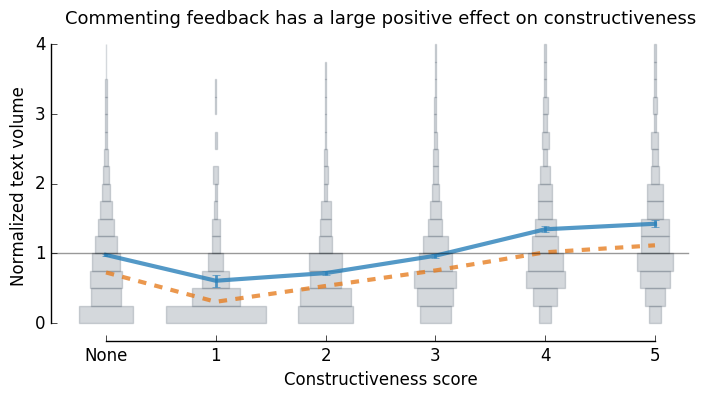

In [1604]:
hists = defaultdict(list)
for _, v in ds1.items():
    try:
        text_length = np.sum(v['text_length']) * 1.0 / np.mean(assignments_text_length[v['assignment']])
    except KeyError:
        continue
        
    if np.isnan(text_length):
        continue
        
    hists[v['feedback_grade']].append(
        text_length
    )

bins = np.linspace(0, 4, 17)
hists_mean = np.mean([v for h in hists.values() for v in h])
hists_median = np.median([v for h in hists.values() for v in h])

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), frameon=False)

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    medians.append(np.median(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, _ = np.histogram(h, bins=bins, normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        if bc == 0: continue
        w = bc*0.5
        rect = mpatches.Rectangle([v-w/2, b], w, abs(bins[0]-bins[1]), lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)

plt.plot([-0.5, 5.3], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4)

plt.xlim([-0.5, 5.5])
plt.ylim([-0.25, 4.2])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks(np.linspace(0, 4, 5), fontsize=12)

plt.xlabel("Constructiveness score", fontsize=12)
plt.ylabel("Normalized text volume", fontsize=12)

sns.despine(trim=True)
plt.title("Commenting feedback has a large positive effect on constructiveness", fontsize=13)
plt.savefig("../figures/feedback0.png")
plt.show()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


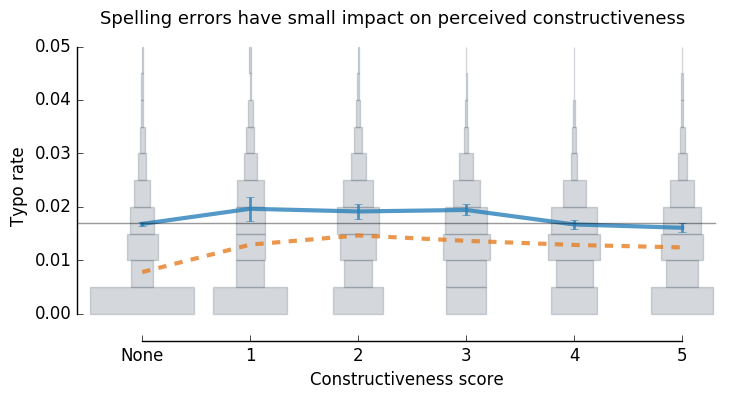

In [1605]:
hists = defaultdict(list)
for _, v in ds1.items():
    try:
        text_count = np.sum(v['text_length'])
        typo_count = np.sum(v['text_typo_rate'])
        typo_rate = typo_count * 1.0 / text_count
    except KeyError:
        continue
        
    if np.isnan(typo_rate):
        continue
        
    hists[v['feedback_grade']].append(
        typo_rate
    )

bins = np.linspace(0, 0.05, 11)
hists_mean = np.mean([v for h in hists.values() for v in h])
hists_median = np.median([v for h in hists.values() for v in h])

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), frameon=False)

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    medians.append(np.median(h))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, _ = np.histogram(h, bins=bins, normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        if bc == 0: continue
        w = bc*0.01
        rect = mpatches.Rectangle([v-w/2, b], w, abs(bins[0]-bins[1]), lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)

plt.plot([-0.6, 5.3], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4)

plt.xlim([-0.6, 5.5])
plt.ylim([-0.005, 0.053])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks(np.linspace(0, 0.05, 6), fontsize=12)

plt.xlabel("Constructiveness score", fontsize=12)
plt.ylabel("Typo rate", fontsize=12)


sns.despine(trim=True)
plt.title("Spelling errors have small impact on perceived constructiveness     ", fontsize=13)
plt.savefig("../figures/feedback1.png")
plt.show()

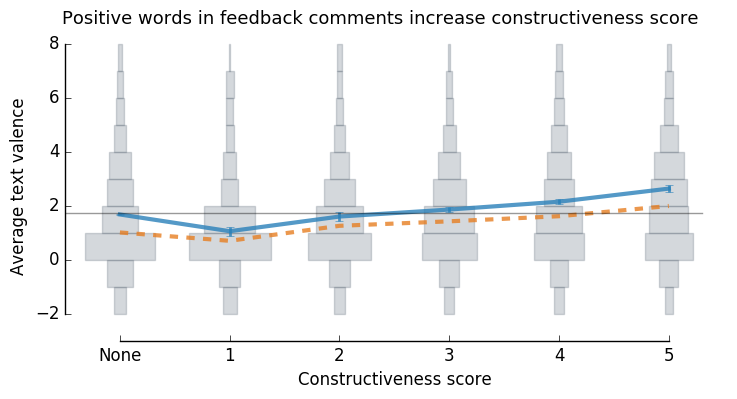

In [1606]:
hists = defaultdict(list)
for _, v in ds1.items():
    if len(v['text_valence']) != len(v['text_length']) or len(v['text_valence']) == 0:
        continue
    
    text_fraction = np.array(v['text_length']) * 1.0 / np.sum(v['text_length'])
    
    text_valence_mean = np.sum([
        valence * fraction
        for valence, fraction in zip(v['text_valence'], text_fraction)
    ])
        
    hists[v['feedback_grade']].append(
        text_valence_mean
    )

bins = np.linspace(-2, 8, 11)
hists_mean = np.mean([v for h in hists.values() for v in h])
hists_median = np.median([v for h in hists.values() for v in h])

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4), frameon=False)

means, medians = [], []
errors = []
lq, uq = [], []
for v, h in hists.items():
    means.append(np.mean(h))
    errors.append(np.std(h) / np.sqrt(len(h)))
    medians.append(np.median(h))
    lq.append(sorted(h)[int(len(h)*0.25)])
    uq.append(sorted(h)[int(len(h)*0.75)])
    bincounts, _ = np.histogram(h, bins=bins, normed=True)
    for bc, b in zip(bincounts, bins[:-1]):
        if bc == 0: continue
        w = bc*2
        rect = mpatches.Rectangle([v-w/2, b], w, abs(bins[0]-bins[1]), lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax.add_collection(collection)

plt.plot(range(6), medians, color="#e67e22", lw=3, ls="--", alpha=0.8)
plt.plot(range(6), means, color="#2980b9", lw=3, ls="-", alpha=0.8)
plt.errorbar(range(6), means, errors, color="#2980b9", lw=0, elinewidth=2, alpha=0.8)

plt.plot([-0.5, 5.3], [hists_mean, hists_mean], c="k", lw=1, alpha=0.4)

plt.xlim([-0.5, 5.5])
plt.ylim([-3, 8.5])
plt.xticks([0, 1, 2, 3, 4, 5], ["None", 1, 2, 3, 4, 5], fontsize=12)
plt.yticks(np.linspace(-2, 8, 6), fontsize=12)

plt.xlabel("Constructiveness score", fontsize=12)
plt.ylabel("Average text valence", fontsize=12)


sns.despine(trim=True)
plt.title("Positive words in feedback comments increase constructiveness score     ", fontsize=13)
plt.savefig("../figures/feedback2.png")
plt.show()

## Student handin quality vs. grading performance

In [1460]:
def get_report_grade_scores(report_grade):
    scores = []
    for answer in db['answer'].find({'report_grade': report_grade['_id']}):
        try:
            brokeit="question"
            question = list(
                db['question'].find({"_id": answer["question"]})
            )[0]
            course = list(
                db['assignment'].find({"_id": report_grade['assignment']})
            )[0]['course']
        except IndexError:
            # something is wrong with this course
            breaker.append(brokeit)
            continue

        # Avoid demo courses!
        if "demo" in list(db['course'].find({"_id": course}))[0]["title"].lower():
            continue

        # Compute normalized numerical score. If rubric doesn't have one, set it 
        # to None, and handle it down the road.
        if "numericalAnswers" in question and "numerical_answer" in answer:
            normalized_score = answer['numerical_answer'] * 1.0 / max(map(int, question['numericalAnswers'].keys()))
        elif "boolean_answer" in answer:
            normalized_score = answer['boolean_answer'] * 1.0 / 2
        else:
            continue
            #normalized_score = None
        
        scores.extend([normalized_score])
    
    return scores


students = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
assignments = defaultdict(list)
handins = defaultdict(list)

c = 0
for _c, student in enumerate(db['user'].find()):
    
    if _c < c:
        continue
    
    print _c,
    
    received_scores_on_assignments = defaultdict(list)
    given_scores_to_handins = {}
    received_feedback_grade = {}
    
    for handin in db['handin'].find({"students": {'$in': [student['_id']]}}):
        for report_grade in db['report_grade'].find({'handin': handin['_id']}):
            scores = get_report_grade_scores(report_grade)            
            received_scores_on_assignments[handin['assignment']].append(np.mean(scores))
            
    for report_grade in db['report_grade'].find({'giver': student['_id'], "handin": {"$exists": True}}):
        scores = get_report_grade_scores(report_grade)
        given_scores_to_handins[report_grade['handin']] = np.nanmean(scores)
        try:
            received_feedback_grade[report_grade['handin']] = report_grade['feedback_grade']
        except KeyError:
            pass
        
    if received_scores_on_assignments == defaultdict(list) \
    or given_scores_to_handins == defaultdict(list):
        continue
    
    # For student
    students[student['_id']]['received_scores_on_assignments'] = received_scores_on_assignments
    students[student['_id']]['given_scores_to_handins'] = given_scores_to_handins
    students[student['_id']]['received_feedback_grade'] = received_feedback_grade
    
    # For normalization
    for assignment, score in received_scores_on_assignments.items():
        assignments[assignment].append(score)
    for handin, score in given_scores_to_handins.items():
        handins[handin].append(score)
    
    c += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

CursorNotFound: cursor id '38910889420' not valid at server

In [1498]:
received_grades, given_grades = [], []
processed_students = []

for _student, data in students.items():
    if _student in processed_students:
        continue
    
    _received_grades = np.nanmean([
        np.nanmean(scores) - np.nanmean([np.nanmean(_a) for _a in assignments[assignment]])
        for assignment, scores in data['received_scores_on_assignments'].items()
    ])
    _given_grades = np.nanmean([
        score - np.nanmean(handins[handin])
        for handin, score in data['given_scores_to_handins'].items()
    ])
    

    if np.isnan(_received_grades) or np.isnan(_given_grades):
        continue
    
    received_grades.append(_received_grades)
    given_grades.append(_given_grades)
    
    processed_students.append(_student)

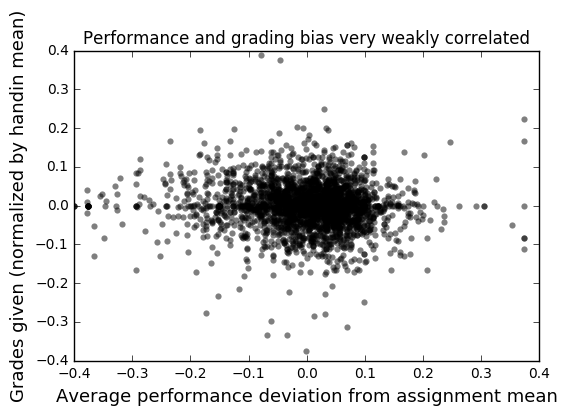

In [1521]:
plt.figure(frameon=False)
#sns.kdeplot(np.array(received_grades), np.array(given_grades), shade=True, cmap=plt.get_cmap("Greys"))
plt.scatter(received_grades, given_grades, lw=0, alpha=0.5, c="k")
plt.xlabel("Average performance deviation from assignment mean", fontsize=13)
plt.ylabel("Grades given (normalized by handin mean)", fontsize=13)
plt.title("Performance and grading bias very weakly correlated")
plt.xlim(-0.4, 0.4)
plt.ylim(-0.4, 0.4)
plt.show()

In [1517]:
pearsonr(received_grades, given_grades)

(-0.055851119461609158, 0.0026414440040161431)

## Academic performance vs. feedback score

In [1450]:
received_grades1, feedback_scores = [], []
processed_students1 = []

for _student, data in students.items():
    
    if _student in processed_students1:
        continue
        
    if not 'received_feedback_grade' in data:
        continue
        
    _received_grades = np.nanmean([
        np.mean(scores) - np.nanmean(assignments[assignment])
        for assignment, scores in data['received_scores_on_assignments'].items()
    ])
    
    _feedback_scores = np.nanmean([
        score
        for handin, score in data['received_feedback_grade'].items()
    ])
    
    if np.isnan(_received_grades) or np.isnan(_feedback_scores):
        continue
    
    received_grades1.append(_received_grades)
    feedback_scores.append(_feedback_scores)
    
    processed_students1.append(_student)

In [1563]:
received_grades1, feedback_scores = zip(*sorted(zip(received_grades1, feedback_scores), key=lambda kv: kv[0]))
#feedback_scores1 = savgol_filter([f + np.random.random()-1 if True else f for f in feedback_scores], 21, 1)
feedback_scores1 = [f + np.random.random()-1 if True else f for f in feedback_scores]

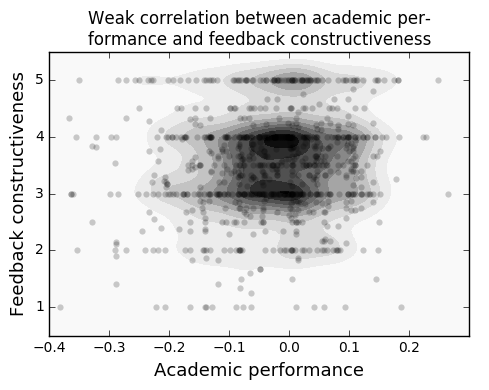

In [1581]:
plt.figure(figsize=(5, 4), frameon=False)
sns.kdeplot(np.array(received_grades1), np.array(feedback_scores), shade=True, cmap=plt.get_cmap("Greys"))
plt.scatter(received_grades1, feedback_scores, lw=0, alpha=0.2, color="black")
plt.xlabel("Academic performance", fontsize=13)
plt.ylabel("Feedback constructiveness", fontsize=13)
plt.title("Weak correlation between academic per-\nformance and feedback constructiveness")
plt.xlim(-0.4, 0.3)
plt.ylim(0.5, 5.5)
plt.tight_layout()
plt.savefig("../figures/academicperformance_vs_constructiveness.png")
plt.show()

In [1573]:
print pearsonr(received_grades1, feedback_scores)

(0.11556732005497301, 0.00093522279059444981)


In [970]:
x_, y_ = zip(*[(_x, _y) for _x, _y in zip(x, y) if _y != 0])

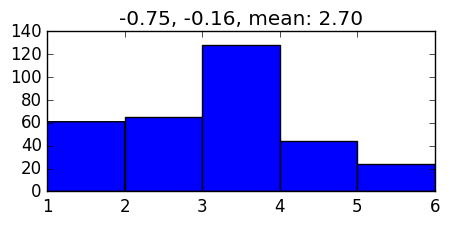

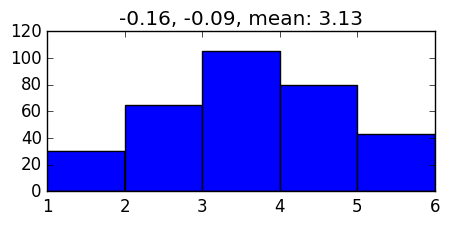

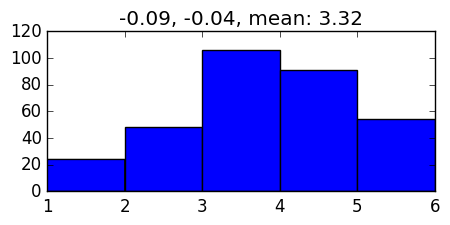

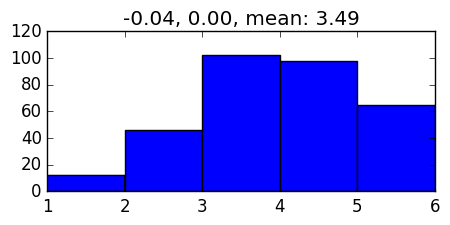

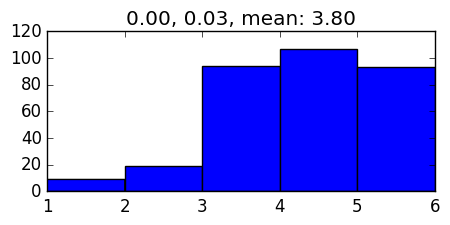

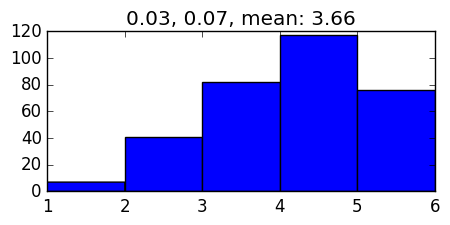

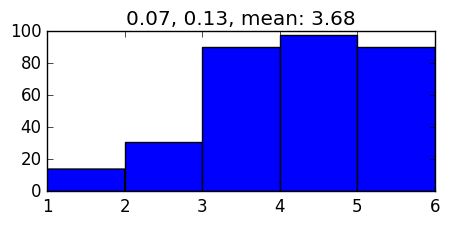

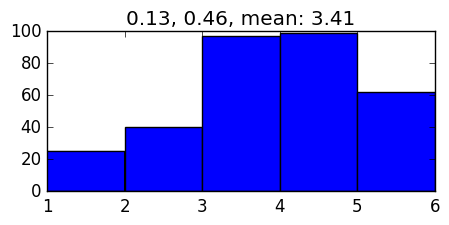

In [971]:
steps = 9
for lp, up in zip(np.linspace(0, 1, steps)[:-1], np.linspace(0, 1, steps)[1:]):
    x__, y__ = zip(*zip(x_, y_)[int(len(x_)*lp):int(len(x_)*up)])
    
    plt.figure(figsize=(5, 2), frameon=False)
    plt.title("%0.2f, %0.2f, mean: %0.2f" % (min(x__), max(x__), np.mean(y__)))
    plt.hist(y__, bins=range(1, 7))
    plt.show()

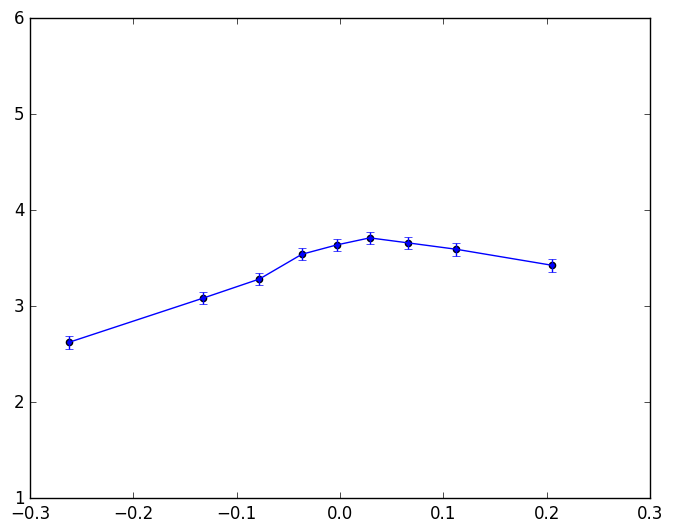

In [401]:
steps = 10

a, b, c = [], [], []
for lp, up in zip(np.linspace(0, 1, steps)[:-1], np.linspace(0, 1, steps)[1:]):
    x__, y__ = zip(*zip(x_, y_)[int(len(x_)*lp):int(len(x_)*up)])
    a.append(np.mean(x__))
    b.append(np.mean(y__))
    c.append(np.std(y__) / np.sqrt(len(y__)))

plt.figure(frameon=False)
plt.errorbar(a, b, c)
plt.scatter(a, b)
plt.ylim([1, 6])
plt.show()

In [974]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(np.mean(v['normalized_scores']))

x, y = [], []
for v, h in hists.items():
    x.extend(h)
    y.extend([v]*len(h))

x, y = zip(*sorted(zip(x, y), key=lambda kv: kv[0]))

x_, y_ = zip(*[(_x, _y + np.random.random() - 1) for _x, _y in zip(x, y) if _y != 0])

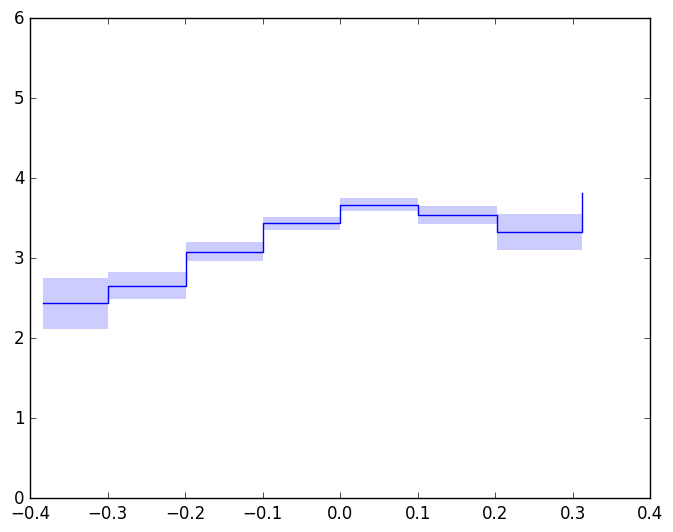

In [961]:
def get_x_y_steps(x, y, where="post"):
    if where == "post":
        x_step = [x[0]] + [_x for tup in zip(x, x)[1:] for _x in tup]
        y_step = [_y for tup in zip(y, y)[:-1] for _y in tup] + [y[-1]]
    elif where == "pre":
        x_step = [_x for tup in zip(x, x)[:-1] for _x in tup] + [x[-1]]
        y_step = [y[0]] + [_y for tup in zip(y, y)[1:] for _y in tup]
    return x_step, y_step

#steps = len(y_)
steps = 9
#size = 100

a, b = [], []
c95 = []
for lp, up in zip(np.linspace(-0.4, 0.4, steps)[:-1], np.linspace(-0.4, 0.4, steps)[1:]):
    x__, y__ = zip(*[(_x_, _y_) for _x_, _y_ in zip(x_, y_) if lp < _x_ < up])
    a.append(np.min(x__))
    b.append(np.mean(y__))
    c95.append(mean_confidence_interval(y__, confidence=0.95))

a_, b_ = get_x_y_steps(a, b)
_, c95_ = get_x_y_steps(a, c95)

plt.figure(frameon=False)
plt.fill_between(a_, [_b - _c95 for _b, _c95 in zip(b_, c95_)], [_b + _c95 for _b, _c95 in zip(b_, c95_)], lw=0, alpha=0.2, color="b")
plt.plot(a_, b_)
plt.ylim([0, 6])
plt.show()

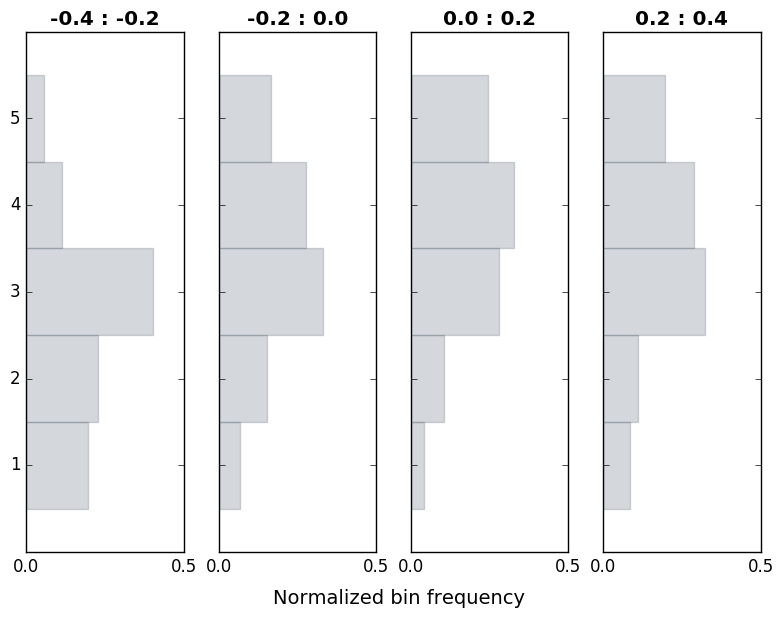

In [1100]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(handins[v['handin']])
    )

x, y = [], []
for v, h in hists.items():
    x.extend(h)
    y.extend([v]*len(h))


x_, y_ = zip(*[(_x, _y) for _x, _y in sorted(zip(x, y), key=lambda kv: kv[0]) if _y != 0])



fig, ax = plt.subplots(1, 4, frameon=False, sharey=True)

steps = 5
for i, (lp, up) in enumerate(zip(np.linspace(-0.4, 0.4, steps)[:-1], np.linspace(-0.4, 0.4, steps)[1:])):
    _, y__ = zip(*[(_x_, _y_) for _x_, _y_ in zip(x_, y_) if lp < _x_ < up])
    heights, bins = np.histogram(y__, normed=True, bins=range(1,7))
    for h, b in zip(heights, bins):
        rect = mpatches.Rectangle([0, b-0.5], h, 1, lw=0)
        collection = PatchCollection([rect], color="#2c3e50", alpha=0.2)
        ax[i].add_collection(collection)
        
    ax[i].set_title("%.01f : %.01f" % (lp, up), fontweight="bold")
    ax[i].set_xlim(0, 0.5)
    ax[i].set_ylim(0, 6)
    ax[i].set_yticks([1, 2, 3, 4, 5])
    ax[i].set_xticks([0, 0.5])
    
plt.annotate("Normalized bin frequency", (0, 0), xytext=(-1.05, -0.6), fontsize=14)
    
plt.tight_layout(w_pad=0.5)
plt.show()
    


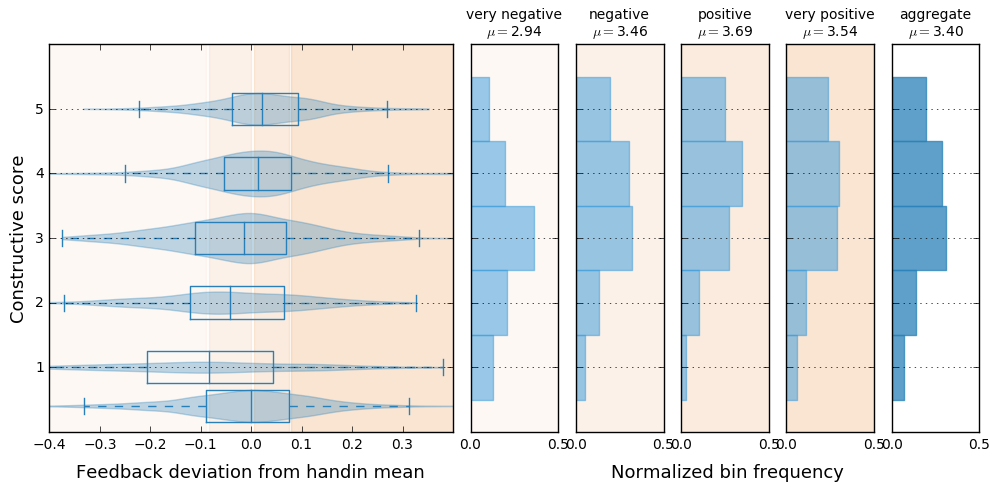

In [1275]:
plt.figure(figsize=(12, 5), frameon=False)
ax = {}
ax[0] = plt.subplot2grid((1, 9), (0,0), colspan=4)
ax[1] = plt.subplot2grid((1, 9), (0,4), colspan=1, sharey=ax[0])
ax[2] = plt.subplot2grid((1, 9), (0,5), colspan=1, sharey=ax[0])
ax[3] = plt.subplot2grid((1, 9), (0,6), colspan=1, sharey=ax[0])
ax[4] = plt.subplot2grid((1, 9), (0,7), colspan=1, sharey=ax[0])
ax[5] = plt.subplot2grid((1, 9), (0,8), colspan=1, sharey=ax[0])
    
# Set background colors
ax[1].patch.set_facecolor("#e67e22")
ax[1].patch.set_alpha(1*0.05)
ax[2].patch.set_facecolor("#e67e22")
ax[2].patch.set_alpha(2*0.05)
ax[3].patch.set_facecolor("#e67e22")
ax[3].patch.set_alpha(3*0.05)
ax[4].patch.set_facecolor("#e67e22")
ax[4].patch.set_alpha(4*0.05)

# Hide yticklabels
for _ax in [ax[1], ax[2], ax[3], ax[4], ax[5]]:
    plt.setp(_ax.get_yticklabels(), visible=False)
    
# Set lims and ticks
ax[0].set_xlim(-0.4, 0.4)
ax[0].set_ylim(-1, 6)
ax[0].set_xticks(np.linspace(-0.4, 0.4, 9)[:-1])
ax[0].grid(axis="y")

# Number of histogram slices
steps = 5

## First plot
x__, _ = zip(*[(_x, _y) for _x, _y in zip(x_, y_) if -0.45 < _x < 0.45])
for c, (_lp, _up) in enumerate(zip(range(0, 100, 25), range(25, 125, 25)), 1):
    lp = np.percentile(x__, _lp); up = np.percentile(x__, _up)
    rect = mpatches.Rectangle([lp+0.005, 0], up-lp-0.005, 6, lw=0)
    collection = PatchCollection([rect], color="#e67e22", alpha=c*0.05)
    ax[0].add_collection(collection)

# Grade split
xx_, yy_ = [], []
for grade in range(1, 6):
    x__, y__ = zip(*[(_x, _y) for _x, _y in zip(x_, y_) if _y == grade and -0.45 < _x < 0.45])
    xx_.append(x__); yy_.append(y__[0])
    violin = ax[0].violinplot(x__, [y__[0]], vert=False, widths=len(x__) * 5.0 * 0.5 / len(x_), showextrema=False)
    for body in violin['bodies']:
        body.set_facecolor('#2980b9')
        body.set_edgecolor("#2980b9")

# Aggregate
x__, y__ = zip(*[(_x, _y) for _x, _y in zip(x_, y_) if -0.45 < _x < 0.45])
xx_.append(x__); yy_.append(0.4)
violin = ax[0].violinplot(x__, [0.4], vert=False, widths=len(x__) * 5.0 * 0.1 / len(x_), showextrema=False)
for body in violin['bodies']:
    body.set_facecolor('#2980b9')
    body.set_edgecolor("#2980b9")


boxplot = ax[0].boxplot(xx_, positions=yy_, vert=False, widths=0.5, showfliers=False)
for attr in boxplot.keys():
    for component in boxplot[attr]:
        component.set_color("#2980b9")
        
# Second plot
    
# Individual
x__, _ = zip(*[(_x, _y) for _x, _y in zip(x_, y_) if -0.45 < _x < 0.45])
for i, (_lp, _up) in enumerate(zip(range(0, 100, 25), range(25, 125, 25)), 1):
    lp = np.percentile(x__, _lp); up = np.percentile(x__, _up)
    _, y__ = zip(*[(_x_, _y_) for _x_, _y_ in zip(x_, y_) if lp < _x_ < up])
    heights, bins = np.histogram(y__, normed=True, bins=range(1,7))
    for h, b in zip(heights, bins):
        rect = mpatches.Rectangle([0, b-0.5], h, 1, lw=0)
        collection = PatchCollection([rect], color="#3498db", alpha=0.5)
        ax[i].add_collection(collection)

    ax[i].set_xlim(0, 0.5)
    ax[i].set_ylim(0, 6)
    ax[i].set_yticks([1, 2, 3, 4, 5])
    ax[i].set_xticks([0, 0.5])
    ax[i].grid(axis="y")
    
    if i == 1:
        ax[i].set_title("very negative\n$\mu = $%.02f" % (np.mean(y__)), fontsize=10)
    if i == 2:
        ax[i].set_title("negative\n$\mu = $%.02f" % (np.mean(y__)), fontsize=10)
    if i == 3:
        ax[i].set_title("positive\n$\mu = $%.02f" % (np.mean(y__)), fontsize=10)
    if i == 4:
        ax[i].set_title("very positive\n$\mu = $%.02f" % (np.mean(y__)), fontsize=10)

# Aggregate
heights, bins = np.histogram(y_, normed=True, bins=range(1,7))
for h, b in zip(heights, bins):
    rect = mpatches.Rectangle([0, b-0.5], h, 1, lw=0)
    collection = PatchCollection([rect], color="#2980b9", alpha=0.75)
    ax[5].add_collection(collection)
   
ax[5].set_title("aggregate\n$\mu = $%.02f" % (np.mean(y_)), fontsize=10)
ax[5].set_xlim(0, 0.5)
ax[5].set_yticks([1, 2, 3, 4, 5])
ax[5].set_xticks([0, 0.5])
ax[5].grid(axis="y")
    
# ylabel
ax[0].set_ylabel("Constructive score", fontsize=13)
# xlabels
plt.annotate("Feedback deviation from handin mean", (0, 0), xytext=(-4.65, -0.7), fontsize=13)
plt.annotate("Normalized bin frequency", (0, 0), xytext=(-1.6, -0.7), fontsize=13)

# Dont overwrite unlesss you know what you are doing
#plt.savefig("../figures/normalized_feedback1.pdf")
plt.show()

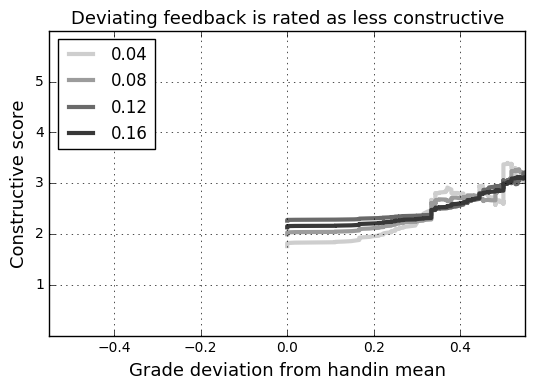

In [1501]:
from scipy.signal import savgol_filter

def make_odd(num):
    if num % 2 == 0:
        num += 1

    return num

x, y = [], []
for v, h in hists.items():
    x.extend(h)
    y.extend([v]*len(h))
x, y = zip(*sorted(zip(x, y), key=lambda kv: kv[0]))
x_, y_ = zip(*[(_x, _y) for _x, _y in zip(x, y) if _y != 0])
x_, y_ = np.array(x_), np.array(y_)

plt.figure(figsize=(5.5, 4), frameon=False)
plt.title("Deviating feedback is rated as less constructive", fontsize=13)

for i, p in enumerate(np.linspace(0.04, 0.16, 4), 1):
    y__ = savgol_filter(y_, make_odd(int(len(x_)*p)), 1)
    plt.plot(x_, y__, label="%0.2f" % p, color=plt.get_cmap("gray")(256-50*i), lw=3)

plt.ylim(0, 6)
plt.xlim(-0.55, 0.55)
plt.yticks([1, 2, 3, 4, 5])

plt.grid(True)
plt.legend(loc="upper left")

plt.xlabel("Grade deviation from handin mean", fontsize=13)
plt.ylabel("Constructive score", fontsize=13)

plt.tight_layout()
#plt.savefig("../figures/normalized_feedback_sliding_window.pdf")
plt.show()

In [628]:
tmp.grid

(0.039215686274509803, 0.039215686274509803, 0.039215686274509803, 1.0)

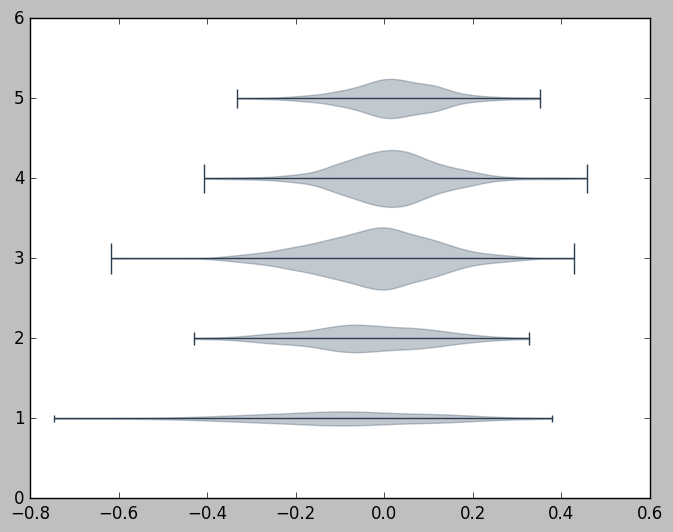

In [783]:
plt.figure()
for grade in range(1, 6):
    x__, y__ = zip(*[(_x, _y) for _x, _y in zip(x_, y_) if _y == grade])
    violin = plt.violinplot(x__, [y__[0]], vert=False, widths=len(x__) * 5.0 * 0.5 / len(x_), points=100)
    for body in violin['bodies']:
        body.set_facecolor('#34495e')
        body.set_edgecolor("#34495e")
    violin['cbars'].set_edgecolor("#2c3e50")
    violin['cmaxes'].set_edgecolor("#2c3e50")
    violin['cmins'].set_edgecolor("#2c3e50")
        
plt.ylim(0, 6)
plt.show()

In [691]:
violin['cbars'].set_linestyle("--")

In [794]:
boxplot.keys()

['boxes', 'fliers', 'medians', 'means', 'whiskers', 'caps']

In [838]:
boxplot

{'boxes': [<matplotlib.lines.Line2D at 0x115a7be90>],
 'caps': [<matplotlib.lines.Line2D at 0x10f5558d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x115962050>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10ff84090>],
 'whiskers': [<matplotlib.lines.Line2D at 0x115a7bd50>,
  <matplotlib.lines.Line2D at 0x115a7b9d0>]}

In [13]:
print len([itmp for itmp in db['course'].find({})])
len([itmp for itmp in db['course'].find({}) if not "demo" in itmp['title'].lower()])

421


351

In [48]:
counter_all = 0
counter = 0

handin_counter = set()
assignment_counter = set()
course_counter = set()
institution_counter = set()
student_counter = set()

for report_grade in db['report_grade'].find({"_id": {"$gt": ObjectId("56fc4c600000000000000000")}}):

    counter_all += 1
    if 'feedback_grade' not in report_grade:
        continue
        
    counter += 1

    handin_counter.add(report_grade['handin'])        
    assignment_counter.add(report_grade['assignment'])    
    course_counter.add(list(db['assignment'].find({"_id": report_grade['assignment']}))[0]['course'])
    try:
        institution_counter.add(
            list(db['course'].find({"_id": list(db['assignment'].find({"_id": report_grade['assignment']}))[0]['course']}))[0]['institution']
        )
    except KeyError:
        pass
    student_counter.add(report_grade['giver'])

In [49]:
print len(handin_counter)
print len(assignment_counter)
print len(course_counter)
print len(institution_counter)
print len(student_counter)
print counter

1646
276
134
26
2359
5370


In [42]:
report_grade

{u'_id': ObjectId('57f44e6948c6c6004bb71265'),
 u'assignment': ObjectId('57cfc93eada07d000fd14774'),
 u'flagged': False,
 u'giver': ObjectId('57d694fcb3162e001047749d'),
 u'handin': ObjectId('57f10e6b80c7460010af216e'),
 u'state': u'ANSWERED',
 u'submitted_at': datetime.datetime(2016, 10, 5, 0, 53, 21, 160000),
 u'time_spent': 75}